In [1]:
%load_ext autoreload
%autoreload 2

# Group Sizes

In [2]:
from ffdata.datasets.cocktail_party import CocktailPartyDataset

dataset = CocktailPartyDataset()
dataset.load_data(groups_file="../data/cocktail_party/groups.txt")
print("Loaded {} frames of groups".format(len(dataset.groups.keys())))

Loaded 320 frames of groups


In [3]:
import matplotlib.pyplot as plt

def extract_group_size_and_stamps(dataset):

    group_size = []    # number of people in the group
    group_stamp = []   # stamp where the group comes from
    for stamp in dataset.groups.keys():
        for group in dataset.groups[stamp]:
            n = len(group)
            if n > 1:
                group_size.append(n)
                group_stamp.append(stamp)

    return group_size, group_stamp

group_size, group_stamp = extract_group_size_and_stamps(dataset)
                
print("Got {} groups total with at least 2 individuals".format(len(group_size)))
print("End stamp - start stamp = ", float(group_stamp[-1]) - float(group_stamp[0]), "seconds")

def plot_hist(data, bins=range(1,9)):

    # the histogram of the data
    n, bins, patches = plt.hist(data, bins=bins, facecolor='g', alpha=0.75)

    plt.xlabel('Group Size')
    plt.ylabel('Quantity')
    plt.title('Histogram of group size')
    plt.show()
    
plot_hist(group_size)

Got 409 groups total with at least 2 individuals
End stamp - start stamp =  1655.063961982727 seconds


Start: 1275403283.267134, End: 1275403393.6041338 (Length: 110.33699989318848)


Start: 1275404827.994096, End: 1275404938.331096 (Length: 110.33699989318848)


Start: 1275404058.133281, End: 1275404168.470281 (Length: 110.33699989318848)


All together.. (n=80)


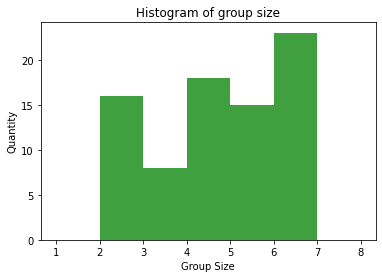

In [4]:
import numpy as np

def plot_distribution_in_range(start_stamp, end_stamp, group_size, group_stamp):
    s = np.array([float(s) for s in group_stamp])
    indices = np.where((s >= start_stamp) & (s < end_stamp))
    gs = np.array(group_size)[indices]
    print("Start: {}, End: {} (Length: {})".format(start_stamp, end_stamp, end_stamp - start_stamp))
    plot_hist(gs)
    return gs

length_sec = 110.337 # results in approx. 20% of the data with the 3 splits below

# plot the distribution only at the beginning
start_stamp = float(group_stamp[0])
end_stamp = start_stamp + length_sec
gs_1 = plot_distribution_in_range(start_stamp, end_stamp, group_size, group_stamp)

# plot distribution at the end
end_stamp = float(group_stamp[-1])
start_stamp = end_stamp - length_sec
gs_2 = plot_distribution_in_range(start_stamp, end_stamp, group_size, group_stamp)

# plot distribution at the middle
unique_stamps = [float(x) for x in list(set(group_stamp))]
unique_stamps.sort()
start_stamp = float(unique_stamps[int(len(unique_stamps)*0.5)]) - (length_sec*0.5)
end_stamp = start_stamp + length_sec
gs_3 = plot_distribution_in_range(start_stamp, end_stamp, group_size, group_stamp)

# plot all 3 segments together
gs = np.hstack((gs_1, gs_2, gs_3))
print("All together.. (n={})".format(gs.shape[0]))
plot_hist(gs)

## Test/train group files in cocktail party

For these files to be generated, run:
    
    ./bin/split_cocktailparty_groups.py -g data/cocktail_party/groups.txt -v 


Loaded 63 frames of groups


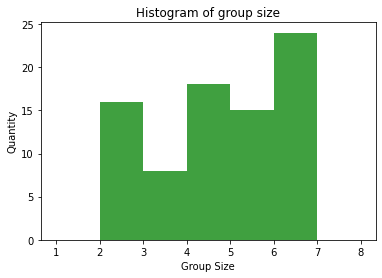

Got 81 groups


In [5]:
dataset = CocktailPartyDataset()
dataset.load_data(groups_file="../data/cocktail_party/groups_test.txt")
print("Loaded {} frames of groups".format(len(dataset.groups.keys())))
group_size, group_stamp = extract_group_size_and_stamps(dataset)
plot_hist(group_size)
print("Got {} groups".format(len(group_size)))

# Inter-personal distances

For every group, let's compute interpersonal distances among group members, and interpersonal distances among non-group members.

In [6]:
dataset = CocktailPartyDataset()
dataset.load_data(groups_file="../data/cocktail_party/groups.txt",
                  features_file="../data/cocktail_party/features.txt")
print("Loaded {} frames of groups".format(len(dataset.groups.keys())))
print("Loaded {} frames of features".format(len(dataset.features.keys())))

Loaded 320 frames of groups
Loaded 24875 frames of features


In [7]:
group_dist = []
group_size = []

for group_stamp in dataset.groups.keys():
    groups = dataset.groups[group_stamp]
    features = dataset.features[group_stamp]
    
    # inter-group distances
    for group_members in groups:
        for i, id1 in enumerate(group_members):
            for j, id2 in enumerate(group_members[i+1:]):
                feat1 = np.array(features[id1][0:2]) # x, y are first features
                feat2 = np.array(features[id2][0:2])
                d = np.linalg.norm(feat1 - feat2)
                group_dist.append(d)
                group_size.append(len(group_members))
                
# print info
print("Group dist:", np.mean(group_dist), "+-", np.std(group_dist), "meters")
print("Got group sizes", list(set(group_size)))
group_dist = np.array(group_dist)
group_size = np.array(group_size)
bins=[x/100.0 for x in range(0,300,5)]

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(231)
ax.hist(group_dist[group_size == 2], bins=bins, facecolor='g', alpha=0.75)
ax.set_title("Group size = 2")
ax = f.add_subplot(232)
ax.hist(group_dist[group_size == 3], bins=bins, facecolor='g', alpha=0.75)
ax.set_title("Group size = 3")
ax = f.add_subplot(233)
ax.hist(group_dist[group_size == 4], bins=bins, facecolor='g', alpha=0.75)
ax.set_title("Group size = 4")
ax = f.add_subplot(234)
ax.hist(group_dist[group_size == 5], bins=bins, facecolor='g', alpha=0.75)
ax.set_title("Group size = 5")
ax = f.add_subplot(235)
ax.hist(group_dist[group_size == 6], bins=bins, facecolor='g', alpha=0.75)
ax.set_title("Group size = 6")
ax = f.add_subplot(236)
ax.hist(group_dist, bins=bins, facecolor='g', alpha=0.75)
ax.set_title("All")
plt.show()


Group dist: 1.1777042386801133 +- 0.4068418090310381 meters
Got group sizes [2, 3, 4, 5, 6]


In [9]:
# Minimum distance within group
min_group_dist = []
group_size = []

for group_stamp in dataset.groups.keys():
    groups = dataset.groups[group_stamp]
    features = dataset.features[group_stamp]
    
    # inter-group distances
    for group_members in groups:
        if len(group_members) == 1: continue
        group_d = []
        for i, id1 in enumerate(group_members):
            for j, id2 in enumerate(group_members[i+1:]):
                feat1 = np.array(features[id1][0:2]) # x, y are first features
                feat2 = np.array(features[id2][0:2])
                d = np.linalg.norm(feat1 - feat2)
                group_d.append(d)
        min_group_dist.append(min(group_d))
        group_size.append(len(group_members))
        
# print info
print("Min group dist:", np.mean(min_group_dist), "+-", np.std(min_group_dist), "meters")
print("Got group sizes", list(set(group_size)))
bins=[x/100.0 for x in range(0,300,5)]
plt.hist(min_group_dist, bins=bins, facecolor='g', alpha=0.75)
plt.show()

Min group dist: 0.699233828104798 +- 0.17218408537777743 meters
Got group sizes [2, 3, 4, 5, 6]
